<h1><center>Rapid Carrier Phase Acquisition for Large QAM Signal Constellations</center></h1>

<h4><center>
    A Thesis<br><br>by<br><br>JASON DILLARD PRESTON
    <br><br><br><br>
    Submitted to Texas A&M University<br>
    in partial fulfillment of the requirements<br>
    for the degree of<br><br>
    MASTER OF SCIENCE<br><br><br><br>
    December 1996<br><br><br>
    Major Subject: Electrical Engineering
</center></h4>

<h5>
Notebook Author: Lance Preston
</h5>

This notebook serves as a replication of the results of Jason Preston's 1996 Master's thesis. A step by step recreation of the results of the original work will be built throughout this notebook along with explanations for any particularly difficult or obscure parts. It aims to more slowly introduce the topics and ideas while also providing in depth coverage of the advanced topics and concepts discussed in the paper. This notebook is not a replacement for the original work, rather it acts as a supplement to the thesis. The original thesis can be viewed at: https://oaktrust.library.tamu.edu/handle/1969.1/ETD-TAMU-1996-THESIS-P73

**Press "Shift + Enter" to run a code block.**

# ABSTRACT (Problem Introduction)

<i>"This work addresses the problem of rapid carrier-phase acquisition for QAM constellations, and specifically for the 32-QAM, 64-QAM, 128-QAM, and 256-QAM constellations, operating over an AWGN channel."</i>

The first sentence of the abstract introduces everything you need to understand going into the first chapter. While it is assumed that you have prior knowledge what these things are in the thesis, this notebook does not. These topics will be explained in detail here. It is, however, assumed that you have a strong understanding of complex numbers and a solid math background. With that in mind, let's work on demystifying this first sentence.

**What is a M-QAM constellation?**

A **Quadrature Amplitude Modulation (QAM) constellation** is a set of points on the imaginary plane. The number, M, before QAM represents the number of points on the plane. The shape that these constellations take on in this work are either perfect squares (64-QAM and 256-QAM), or crosses (32-QAM and 128-QAM). In Python, the constellations will be represented by an array of imaginary numbers. Run the following code to view the shapes.


C:\Users\lance\Desktop\Pet Projects\notebooks\QAM Thesis\thesisplots.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


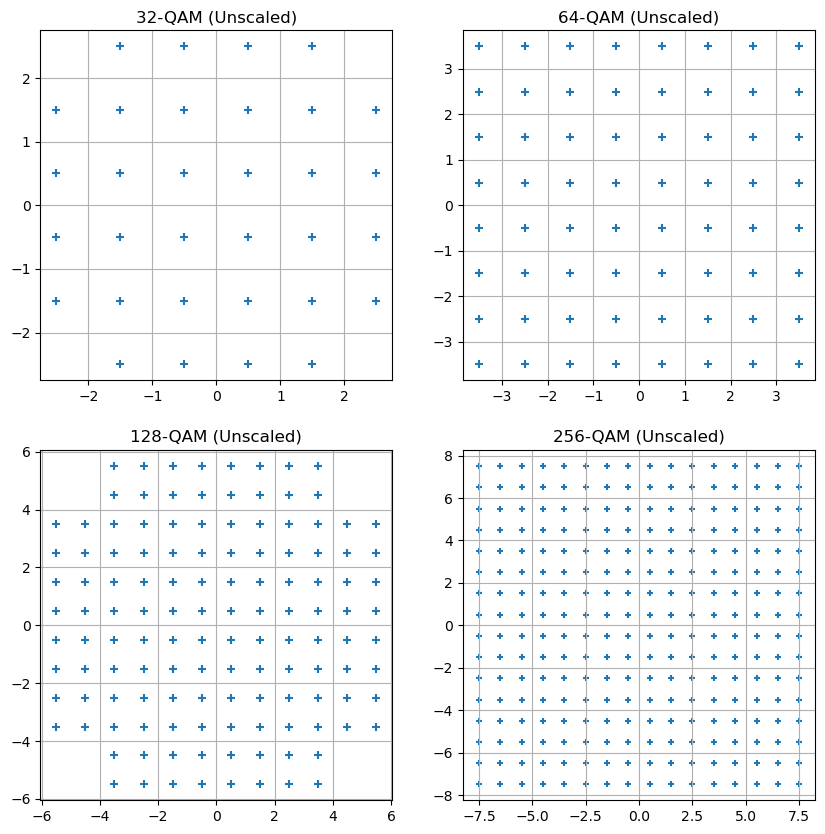

In [1]:
from thesisplots import graph_unscaled_qam_constellations

graph_unscaled_qam_constellations()

Notice that this figure is already nearly identical to fig. 1 in the thesis, with the key difference of the axis scale. This will be corrected at the start of chapter 1.

QAM constellations are a way to represent binary data being sent through **electromagnetic waves**. Think of **Amplitude Modulation (AM)** radio. In an electromagnetic wave, there are actually 2 waves. There is the electric wave and the magnetic wave. By altering the amplitude (strength) of the electric wave we can represent different values on the real axis. Similarly, by changing the amplitude of the magnetic wave, we can represent different values on the imaginary axis. The combination of these two chosen values on the real and imaginary axis allows us to represent any point we want on the imaginary plane and transmit it through an electromagnetic wave. This is how AM radio operates.

By agreeing on a definition for our constellations, we are able to send binary data by choosing a point on a constellation. For example, in the 64-QAM constellation, we have 64 different symbols to choose from. With this many symbols we can send 6 bits of binary data at a time. Exactly what number (0-63) that each symbol represents is arbitrary, so long as the sender and receiver agree upon the definition of each symbol.

**What's the problem?**

The issue comes from error when transmitting these signals. To receive this encoded binary data, there must be some control wave to compare the received wave to. When the phase of the control wave is different from the phase of the sent wave, there is a rotational error in the data. This difference in phase is called the **phase offset** and is represented by the symbol $\theta$. This is demonstrated below.

C:\Users\lance\Desktop\Pet Projects\notebooks\QAM Thesis\thesisplots.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


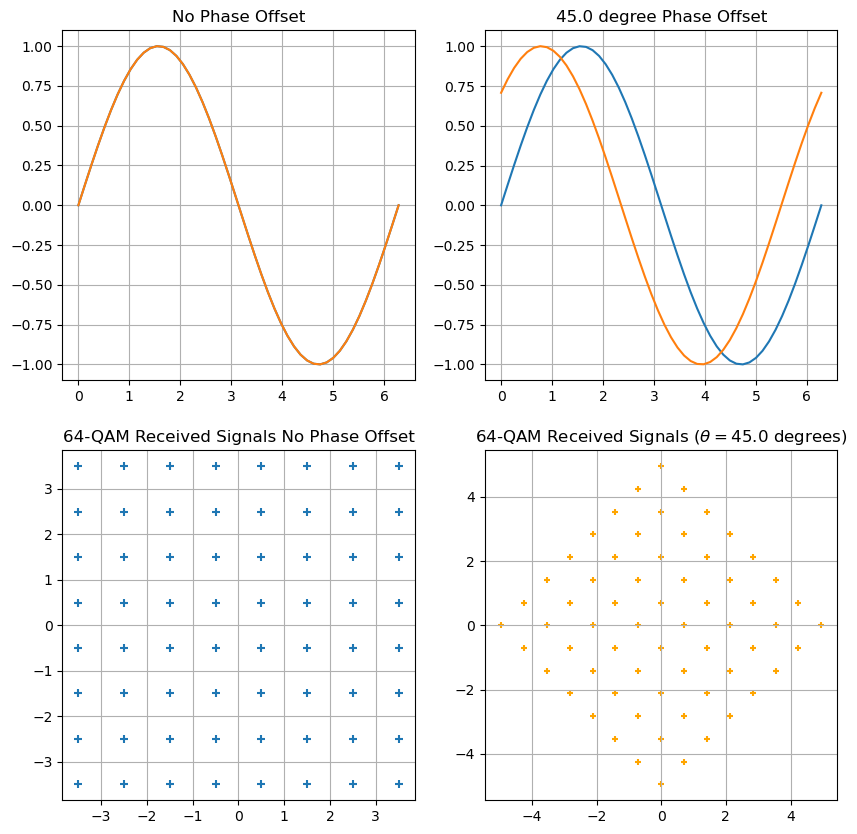

In [2]:
from thesisplots import graph_phase_offset_effects

graph_phase_offset_effects()

Here is an interactive plot so you can have a better understanding of what the phase offset does to signals:

In [3]:
from thesislib import qam64unscaled_new
from thesisplots import phase_offset_demonstration
from ipywidgets import interact, fixed
import numpy as np

time_vals = np.linspace(0, 2*np.pi)
sent_wave = np.sin(time_vals)
qam64_unscaled = qam64unscaled_new()

interact(phase_offset_demonstration, qam=fixed(qam64_unscaled), t_vals=fixed(time_vals), sent_wave=fixed(sent_wave), phase_offset_deg=(0,90,3))

interactive(children=(IntSlider(value=45, description='phase_offset_deg', max=90, step=3), Output()), _dom_cla…

<function thesisplots.phase_offset_demonstration(qam, t_vals, sent_wave, phase_offset_deg)>

With the existence of a phase offset, signals can be corrupted and misinterpreted by the receiver. This paper focuses on finding ways to estimate the value of the phase offset and correcting it. In practice, these signals are sent very, very quickly, thus it is of paramount importance that these algorithms be fast. Hence the title "Rapid Carrier-Phase Aqcuisition for Large QAM Signal Constellations."

**What is an AWGN channel?**

Phase offset isn't the only source of error when transmitting data. Frequency offset can cause a continuous rotation of the received data, and interference can cause noise. In this work it is assumed that there is no frequency offset, as this can be tracked and taken care of in other ways. We will not have to worry about continuous rotation. Noise, on the other hand, affects this problem greatly. In this case, noise refers to a small difference between the signal sent and the signal received. These differences are unpredictable and usually entirely random. Anything could be causing the noise, from atmospheric conditions to interference from another nearby source of electromagnetic waves. In this work, this interference is simulated with an **Additive White Gaussian Noise (AWGN) channel**. All this means is that a point is sampled from a complex normal distribution and added to the signal. Below is a graph showing several signals sent from a 32-QAM constellation with AWGN. In the example below, don't worry about understanding exactly what every number means. We will cover everything below in detail soon.

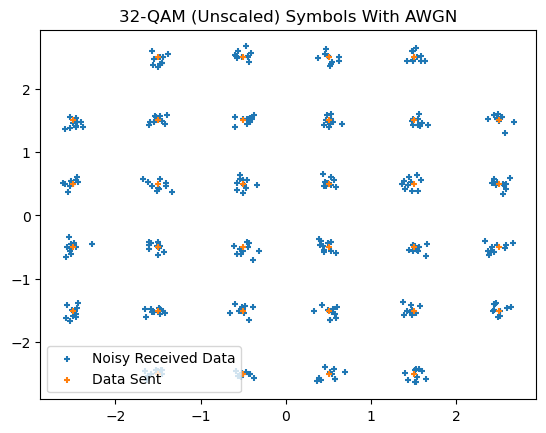

In [4]:
import matplotlib.pyplot as plt
from thesislib import *

snr = linearize_dB(13.0) # For now this value is arbitrary.
                         # We will go over how to choose this value in chapter 1.

K = 10                   # Number of points per signal

qam32_normal = qam32unscaled_new()
qam32_noisy = qam32_normal.repeat(K)
noise = awgn_noise(snr, len(qam32_noisy))
qam32_noisy = qam32_noisy + noise

plt.title("32-QAM (Unscaled) Symbols With AWGN")
plt.scatter(qam32_noisy.real, qam32_noisy.imag, marker="+", s=16)
plt.scatter(qam32_normal.real, qam32_normal.imag, marker="+", s=16)

plt.legend(["Noisy Received Data", "Data Sent"], loc="lower left")

plt.show()

# CHAPTER I

**Scaling the QAM constellations**

***NOTE: In the paper it is stated that "All of the constellations have been normalized to have average energy equal to 1." This is a writing mistake. It should state that all of the constellations are normalized to have an average POWER equal to 1. The constellations considered in the work have an average energy of less than one.***

As mentioned briefly in chapter I section B, all of the constellations considered in the work are scaled to have an average power ("energy" in the thesis) equal to 1. The power of a single symbol is calculated by taking the squared distance from the symbol to the origin. In Python this can be calculated with numpy's absolute value function. The total power of the constellation is the sum of all of the powers of the symbols. The average power can be obtained by dividing this value by the size of the constellation.

<center>
    Average Power $ = \bar{P} = \frac{1}{M} \sum \limits _{n=1}^{M} |c_i|^2$
</center>

Right now, the average power of the QAM constellations are greater than 1. This can be solved by scaling them by the square root of their average power. Doing so will yield a constellation with average power of 1.

<center>
    $\frac{\bar{P}}{\bar{P}} = \frac{1}{M} \sum \limits _{n=1}^{M} \left| \frac{c_i}{\sqrt{\bar{P}}} \right|^2 = 1$
</center>

Average energy for unscaled 64-QAM constellation: 10.5
Average energy for corrected 64-QAM constellation: 1.00


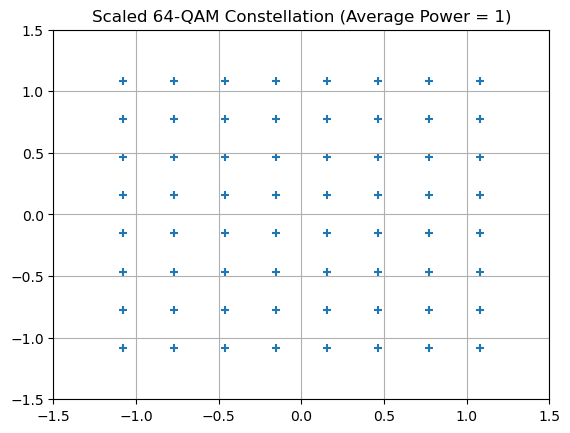

In [5]:
import matplotlib.pyplot as plt
from thesislib import *

qam64 = qam64unscaled_new()

print(f"Average energy for unscaled 64-QAM constellation: {calc_average_power(qam64)}")

qam64_scaled = qam64 / np.sqrt(calc_average_power(qam64)) # Divide each symbol by the sqrt of average power

print(f"Average energy for corrected 64-QAM constellation: {calc_average_power(qam64_scaled):.2f}")

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid()
plt.title("Scaled 64-QAM Constellation (Average Power = 1)")
plt.scatter(qam64_scaled.real, qam64_scaled.imag, marker="+")

plt.show()

The scaled versions of the constellations considered are shown below (Fig. 1).

C:\Users\lance\Desktop\Pet Projects\notebooks\QAM Thesis\thesisplots.py:131: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


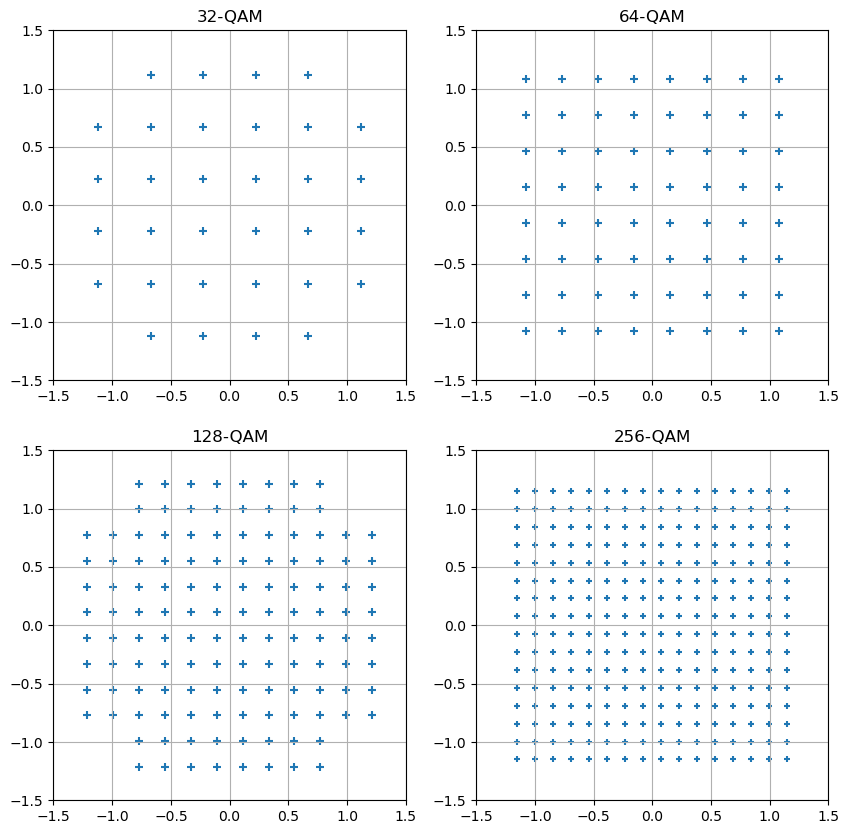

In [6]:
from thesisplots import graph_qam_constellations

# Display Fig. 1
graph_qam_constellations()

**Symbol Error Probability**

Now that the constellations being used have been fully defined, the paper defines the upper bound of the symbol error probability as:

<br>
<center>
    $\DeclareMathOperator\erfc{erfc}$
    $P_N = 2 \cdot \erfc\left(\sqrt{\frac{3\gamma}{2(N-1)}}\right)$
</center>

Learn more about the **complementary error function** ($\erfc$) here: https://en.wikipedia.org/wiki/Error_function  

In this equation, $N$ represents the number of symbols in the constellation, and $\gamma$ represents the signal-to-noise ratio measured in decibels (dB). The following graph shows this equation for all four values of $N$ (constellation sizes) considered in the work.

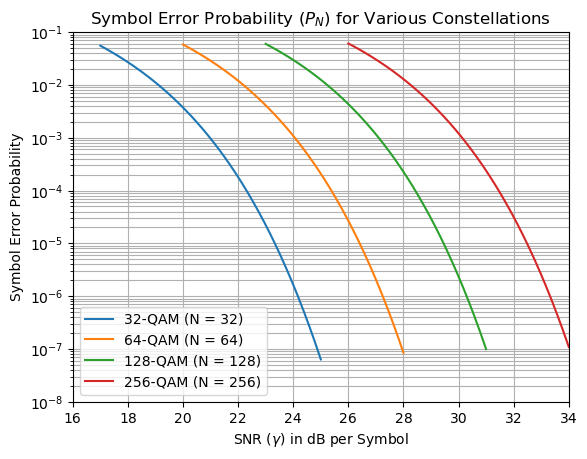

In [7]:
from thesisplots import graph_symbol_err_prob

# Graph P_N for the 4 values of N and various values of SNR
graph_symbol_err_prob()

According to the paper, it is reasonable to expect symbol error probabilities somewhere between about $10^{-2}$ and $10^{-6}$, thus the following signal to noise ratios are chosen for each constellation size:

| Signal Constellation | SNR in dB per symbol (Low end) | SNR in dB per symbol (High end) |
| --------------------:| ------------------------------:| -------------------------------:|
|        32-QAM        |               19               |                24               |
|        64-QAM        |               22               |                27               |
|       128-QAM        |               25               |                30               |
|       256-QAM        |               28               |                33               |


The signal to noise ratio is essentially a way of measuring how extreme the interference is. Below is an interactive plot similar to one we saw in the abstract section of this notebook. It shows a constellation along with several sampled noisy symbols that could result from different SNR values. Use the slider to change the SNR value and see what it does to the received symbols. Note that the SNR is not bounded by the range chosen above for a 32-QAM constellation. This is done intentionally so you can see what extreme SNR values can do to the received signals. 

In [8]:
from ipywidgets import interact, fixed
from thesisplots import snr_demonstration
from thesislib import qam32_new

qam32 = qam32_new()

interact(snr_demonstration, qam=fixed(qam32), snr=(10.0, 40.0, 0.4))

interactive(children=(FloatSlider(value=24.8, description='snr', max=40.0, min=10.0, step=0.4), Output()), _do…

<function thesisplots.snr_demonstration(qam, snr)>

The noise is generated by sampling two values from a normal distribution, one for the real part and one for the imaginary part of the AWGN. The normal distribution sampled has a mean of 0 and a standard deviation of $\frac{N_0}{2}$. This $N_0$ term is given in terms of the signal-to-noise ratio, as well as the expected value (average) of the power of the constellation. Since the constellations have all been normalized to have an average power of 1, however, this $N_0$ term simply becomes

<br>
<center>
    $N_0 = \frac{E[|c_i|^2]}{\gamma} = \frac{1}{\gamma}$
</center>

**The Cramer-Rao Bound**

In order to measure the performance of algorithms, the **Cramer-Rao bound (CRB)** is derived as:

<br>
<center>
    CRB $ = \frac{1}{2K\gamma}$
</center>

The CRB provides a lower bound for the expected mean square error of an estimator. This means that whatever algorithms are derived for estimating the phase offset, their performance over time will be limited by the CRB. Thus the performance of each algorithm can be measured by how close they come to achieving the CRB. The CRB is dependent on $\gamma$ (SNR) and $K$ (the number of symbols transmitted, also called the **vector length**). Below is an interactive graph that shows the CRB for various values of $\gamma$ with the x-axis representing the vector length. Use the slider to change the signal to noise ratio.

In [1]:
from ipywidgets import interact, fixed
from thesisplots import crb_demonstration
import numpy as np

vec_lengths = np.arange(10,101,1)

interact(crb_demonstration, k_vals=fixed(vec_lengths), snr=(19.0, 30.0, .1))

interactive(children=(FloatSlider(value=24.5, description='snr', max=30.0, min=19.0), Output()), _dom_classes=…

<function thesisplots.crb_demonstration(k_vals, snr)>

# CHAPTER II

**Maximum Likelihood Phase Estimation**

We now have all the tools we need to derive and measure the performance of an estimator algorithm. The first algorithm we will look at will be the **maximum likelihood (ML)** estimation. The equation for the log-likelihood function as derived in the paper is shown below:

<br>
<center>
    $Ł(r|\theta) = \sum \limits _{k=1}^{K} \ln \left[\sum \limits _{i=1}^{N} \exp \left(-\gamma \cdot |r(k)e^{-j\theta} - c_i|^2 \right) \right]$
</center>

In this equation, $K$ represents the vector length (# symbols sent), $N$ is the constellation size, $\gamma$ is the SNR, $r(k)$ is the k-th signal received, $j$ is the imaginary unit, $\theta$ is the value we are measuring this function at (phase offset guess), and $c_i$ is the i-th symbol in the actual constellation. 

The way this algorithm works is fairly simple. For some value of $\theta$ between $0^{\circ}$ and $90^{\circ}$, we apply a clockwise rotation of $\theta$ to the received symbols to try to undo the phase offset error. We then, for every symbol received, sum the squared error to every symbol in the constellation and take the natural log. By doing this for every value of $\theta$ from $0^{\circ}$ to $90^{\circ}$, we can get a good idea of what the phase offset is by looking at the maximum value of the log-likelihood function. The interactive plot below demonstrates how evaluating the ML equation at every point of $\theta$ can give us a good idea of what the phase offset is. Use the slider to adjust the actual value of the phase offset. You are also able to adjust a slider to see what different guesses of $\theta$ will do to the received data. Note that when receiving real world data, the true phase offset will not be known and is considered a random parameter in the thesis.

In [1]:
from thesisplots import log_likelihood_demonstration
from thesislib import *
from ipywidgets import interact, fixed
import numpy as np

K = 100                    # Vector length
snr = QAM32_SNR_HIGH       # 24.0 dB as found earlier in ch. 1
noise = awgn_noise(snr, K) # Precalculated to avoid changing the shape of the graphs every time a value is changed

qam32 = qam32_new()
sent_signals = np.random.choice(qam32, K) # Also precalculated for same reason as AWGN

interact(log_likelihood_demonstration, qam=fixed(qam32), noise=fixed(noise), sent_stream=fixed(sent_signals), snr=fixed(snr), phase_offset=(0,90,3), theta_guess=(0,90,3))

interactive(children=(IntSlider(value=45, description='phase_offset', max=90, step=3), IntSlider(value=45, des…

<function thesisplots.log_likelihood_demonstration(qam, noise, sent_stream, snr, phase_offset, theta_guess)>

Figure 3 in the thesis was created by plotting the log-likelihood function for a 128-QAM constellation with a phase offset of 45.0 degrees. One such graph is shown below.

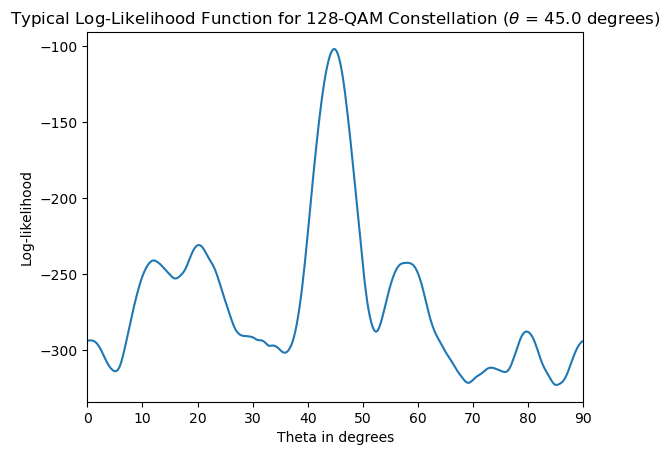

In [2]:
from thesisplots import graph_log_likelihood

graph_log_likelihood()

Notice that in the interactive plot, the maximum value of the log-likelihood function is achieved when theta_guess is nearly equal to the true phase offset. This is the point of the maximum likelihood estimator: to find the value of theta that maximizes the log-likelihood. To do this, the log-likelihood function will be evaluated at 2 degree increments of $\theta$. Below is an example graph that demonstrates how this approach can estimate loosely what the phase offset is.

True Phase Offset: 15.74324
Best Theta Guess: 16


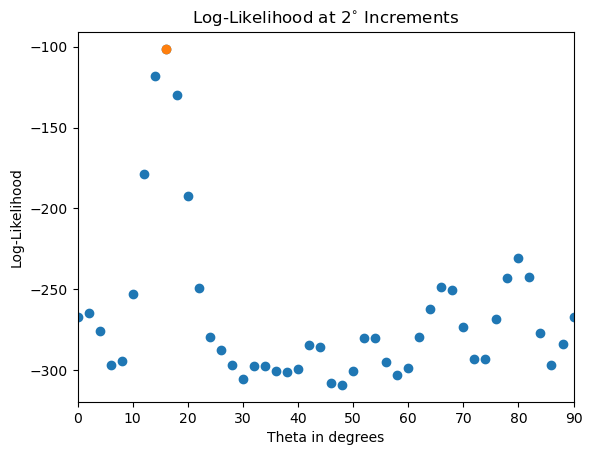

In [3]:
from thesisplots import graph_ml_estimator
from thesislib import *
import numpy as np

graph_ml_estimator()

This approach can get fairly close to the maximum of the log-likelihood function, but the estimate can be improved by using a second order Newton's method. Newton's method can be explored here: https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization

As the graphs below show, the new estimate for $\theta$ is much closer to the maximum of the log-likelihood function. The continuous log-likelihood function has been graphed in the plots below, however be aware that when calculating the best estimate most of these values are not considered. Only the values at the dots are used to calculate the best $\theta$ estimate. They are simply there for you to see the actual shape of the log-likelihood function.

C:\Users\lance\Desktop\Pet Projects\notebooks\QAM Thesis\thesisplots.py:320: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Actual Phase Offset: 15.74324
Best Rough Estimate: 16.0
Best Guess with Newton's Method: 15.786973194269741


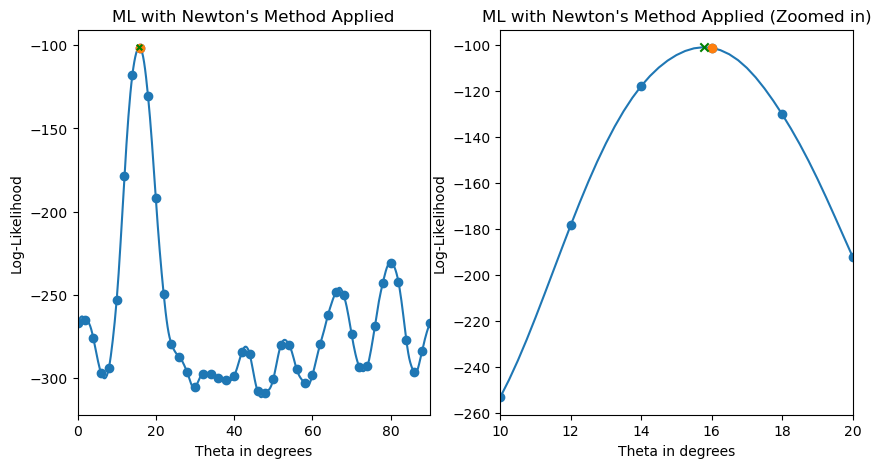

In [4]:
from thesisplots import graph_ml_estimator_with_newtons

graph_ml_estimator_with_newtons()

This completes the ML algorithm, and now its performance can be measured with respect to the CRB. The **squared error** ($\epsilon$) of the ML estimate is what will be compared to the CRB. Due to the periodicity (repitition) of the log-likelihood function every $90^{\circ}$, the squared error is defined in the paper as:

<br>
<center>
    $$
    \epsilon = \min \begin{cases} (\theta - \hat{\theta})^2 \\ (\theta - \hat{\theta} + 90^{\circ})^2 \\ (\theta - \hat{\theta} - 90^{\circ})^2 \end{cases}
    $$
</center>

Here, $\theta$ is the true phase offset, and $\hat{\theta}$ is the estimated phase offset from the ML algorithm. Like in the paper, 1000 tests will be performed in which a random $\theta$ will be generated. The average $\epsilon$ will be measured over these 1000 iterations. These tests take several minutes to run, so the results have been precomputed and are graphed below. Tests are performed for each constellation at both the high and low ends of the chosen SNR values.

C:\Users\lance\Desktop\Pet Projects\notebooks\QAM Thesis\thesisplots.py:377: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


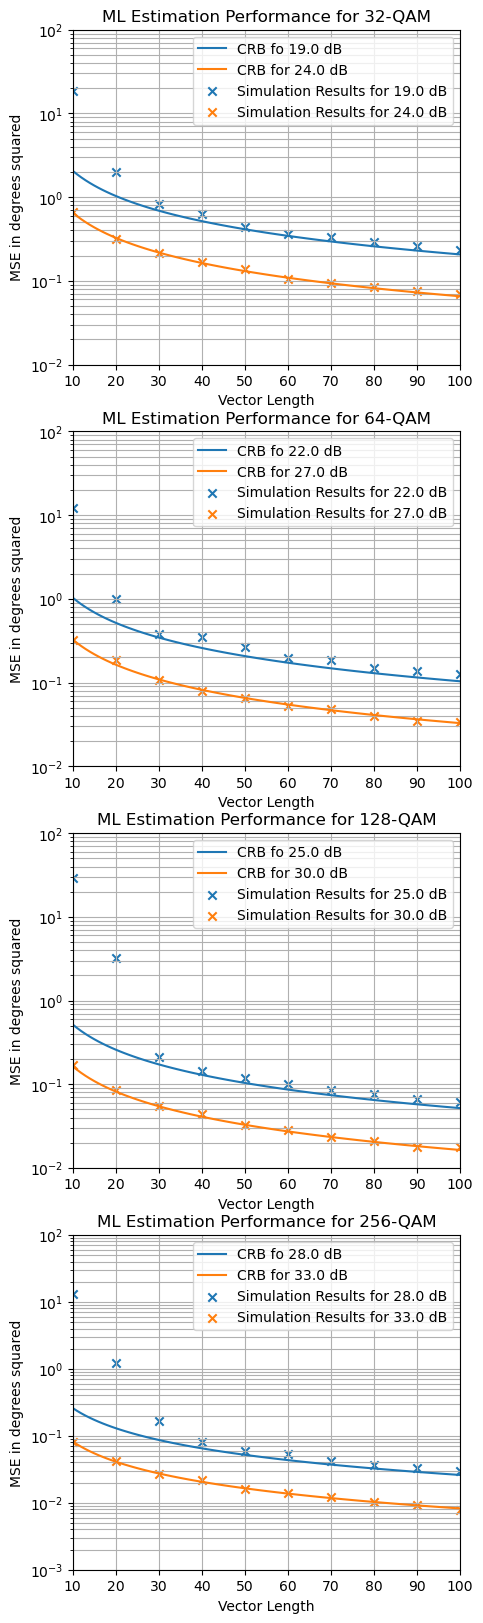

In [5]:
from thesisplots import graph_ml_results

graph_ml_results()

As you can see, the ML estimation algorithms does a very good job estimating the value of $\theta$ for most vector lengths. In most cases, the MSE measures very close to the CRB. Exceptions to this occur when there aren't enough symbols in the vector to always give the algorithm a good idea of what the phase offset may be. The results of these performance tests are clear; the ML algorithm is very good at accurately estimating the value of $\theta$, but it is simply too slow to be used for real world phase offset estimation. Phase offset estimation must be as fast as possible to allow the transmission of the greatest amount of data. Between the inefficiency of calculating the log-likelihood for 45 different values of $\hat{\theta}$, as well as numerically calculating the first and second derivatives for the second order Newton's method (which requires calculating the log-likelihood at 6 more points), this algorithm is simply too slow. The goal of the next algorithm is to optimize and simplify the established ML algorithm to reduce the time it takes to estimate $\theta$.

**A Suboptimal Version of the ML Algorithm**

To improve the speed greatly, we look to the **Suboptimal Maximum Likelihood (SML)** algorithm. In the interest of cutting down on computational costs, it would be extremely desireable to reduce the amount of symbols in the QAM constellation that need to be used to compute the log-likelihood without significantly changing the shape of the log-likelihood graph. Fortunately, there is a way to accomplish this.

Several symbols in the QAM constellations share the same level of energy (distance from the origin). As explained in the paper, symbols have a much greater effect on the log-likelihood function if they are closer in energy level to the received symbol. This idea is shown below. Use the slider to change the "received symbol" and see which points would need to be involved in the suboptimal log-likelihood calculation. The parameter $p$ represents how many nearby sets of symbols to consider in the calculation as well. Higher values of $p$ will increase the accuracy of the $\hat{\theta}_{SML}$ (SML estimate for $\theta$), but will come at a higher computational cost. Note that in this demonstration, the received symbols lie on existing points in the constellation (no noise).

In [6]:
from ipywidgets import interact
from thesisplots import energy_levels_demonstration

interact(energy_levels_demonstration, symbol=(1,8,1), p=(0,5,1))

interactive(children=(IntSlider(value=4, description='symbol', max=8, min=1), IntSlider(value=2, description='…

<function thesisplots.energy_levels_demonstration(symbol, p)>

As we will see later on, the optimal value of $p$ for the 256-QAM constellation is 3. This means that with only the symbols in 7 total energy levels (3 above, 3 below, and the 1 closest to the received symbol), we can estimate $\hat{\theta}_{SML}$ without a great loss of accuracy. Below are tables detailing exactly how each QAM constellation is broken into energy levels. In the tables, $L$ is the number of energy levels in the constellation, $l$ represents a specific energy level, $M_l$ represents the number of symbols in an energy level, and $|c_l|$ represents the energy at that level. 

<br>

| 32-QAM ($L=5$)        |
|:---------------------:|

| $l$ | M$_l$ | $|c_l|$ |
| --- |:-----:|:-------:|
|  1  |   4   | 0.3343  |
|  2  |   8   | 0.7476  |
|  3  |   4   | 1.0029  |
|  4  |   8   | 1.2054  |
|  5  |   8   | 1.3784  |

<br><br>

| 64-QAM ($L=9$)        |
|:---------------------:|

| $l$ | M$_l$ | $|c_l|$ |
| --- |:-----:|:-------:|
|  1  |   4   | 0.2323  |
|  2  |   8   | 0.5195  |
|  3  |   4   | 0.6970  |
|  4  |   8   | 0.8377  |
|  5  |   8   | 0.9580  |
|  6  |  12   | 1.1617  |
|  7  |   8   | 1.2512  |
|  8  |   8   | 1.4133  |
|  9  |   4   | 1.6264  |

<br><br>

| 128-QAM ($L=16$)      |
|:---------------------:|

| $l$ | M$_l$ | $|c_l|$ |   | $l$ | M$_l$ | $|c_l|$ |
| --- |:-----:|:-------:|   | --- |:-----:|:-------:|
|  1  |   4   | 0.1658  |   |  9  |   8   | 1.0614  |
|  2  |   8   | 0.3707  |   | 10  |   8   | 1.1120  |
|  3  |   4   | 0.4973  |   | 11  |   4   | 1.1604  |
|  4  |   8   | 0.5977  |   | 12  |   8   | 1.2068  |
|  5  |   8   | 0.6835  |   | 13  |   8   | 1.2947  |
|  6  |  12   | 0.8288  |   | 14  |  16   | 1.3364  |
|  7  |   8   | 0.8927  |   | 15  |   8   | 1.4163  |
|  8  |   8   | 1.0083  |   | 16  |   8   | 1.5283  |

<br><br>

| 256-QAM ($L=32$)      |
|:---------------------:|

| $l$ | M$_l$ | $|c_l|$ |   | $l$ | M$_l$ | $|c_l|$ |   | $l$ | M$_l$ | $|c_l|$ |   | $l$ | M$_l$ | $|c_l|$ |
| --- |:-----:|:-------:|   | --- |:-----:|:-------:|   | --- |:-----:|:-------:|   | --- |:-----:|:-------:|
|  1  |   4   | 0.1157  |   |  9  |   8   | 0.7407  |   | 17  |  16   | 1.0665  |   | 25  |  16   | 1.2933  |
|  2  |   8   | 0.2587  |   | 10  |   8   | 0.7760  |   | 18  |   8   | 1.0913  |   | 26  |   8   | 1.3540  |
|  3  |   4   | 0.3470  |   | 11  |   4   | 0.8098  |   | 19  |   8   | 1.1393  |   | 27  |   8   | 1.3930  |
|  4  |   8   | 0.4171  |   | 12  |   8   | 0.8422  |   | 20  |   8   | 1.1626  |   | 28  |   8   | 1.4309  |
|  5  |   8   | 0.4770  |   | 13  |   8   | 0.9035  |   | 21  |   8   | 1.2077  |   | 29  |   4   | 1.5038  |
|  6  |  12   | 0.5784  |   | 14  |  16   | 0.9326  |   | 22  |   8   | 1.2297  |   | 30  |   8   | 1.5215  |
|  7  |   8   | 0.6230  |   | 15  |   8   | 0.9884  |   | 23  |   8   | 1.2513  |   | 31  |   8   | 1.6236  |
|  8  |   8   | 0.7037  |   | 16  |   4   | 1.0411  |   | 24  |   4   | 1.2725  |   | 32  |   4   | 1.7352  |

The algorithm works identically to the ML algorithm, with the only difference in the log-likelihood function. The new log-likelihood function is defined as:

<br>
<center>
    $\tilde{L}(r|\theta) = \sum \limits _{k=1}^{K} \ln \left[\sum \limits _{l=d_k - p}^{d_k + p} \left( \sum \limits _{m=1}^{M_l} \exp \left(-\gamma \cdot |r(k)e^{-j\theta} - c_{lm}|^2 \right) \right) \right]$
</center>

In this equation, $d_k$ represents the energy level that is closest to that of the received symbol, $r(k)$. This log-likelihood function only considers the symbols in the $d_k$ energy level, as well as the symbols in the $p$ surrounding energy levels. For example, for a 256-QAM constellation if $d_k = 7$ and $p = 2$, then the energy levels considered will be $l \in \{5,6,7,8,9\}$ for a total of 44 symbols. This is a significant reduction from the full 256 symbols that would have been used in the ML algorithm. In theory, this will speed up computation greatly without drasticly changing the shape of the log-likelihood function. The difference between the log-likelihood functions is shown below for the same stream of received symbols.

C:\Users\lance\Desktop\Pet Projects\notebooks\QAM Thesis\thesisplots.py:435: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


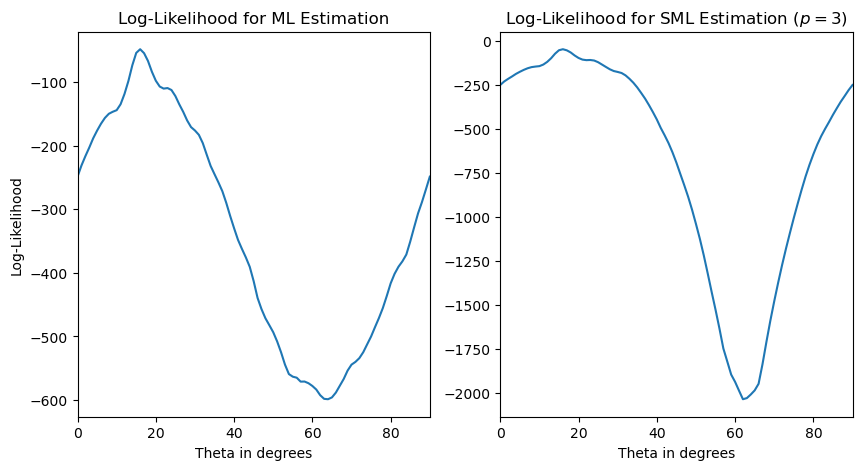

In [1]:
from thesisplots import graph_both_log_likelihoods

graph_both_log_likelihoods()

Much of the detail has been lost due to the exclusion of the majority of the QAM symbols when calculating the log-likelihood function. However, the general shape of the function remains largely the same, and the value of $\theta$ that results in the maximum likelihood is still in roughly the same place. Below is an interactive graph that allows you to see the effect of changing the value of $p$. Higher values of $p$ result in the inclusion of more symbols in the log-likelihood calculations.

In [2]:
from ipywidgets import interact
from thesisplots import sml_p_demonstration

interact(sml_p_demonstration, p=(0,5,1))

interactive(children=(IntSlider(value=2, description='p', max=5), Output()), _dom_classes=('widget-interact',)…

<function thesisplots.sml_p_demonstration(p)>

This clearly shows that the marginal benefit of increasing $p$ quickly diminishes. With only a small portion of the total set of symbols in a constellation, the same maximum can be roughly estimated. As with the ML algorithm, this suboptimal log-likelihood function will be evaluated at 2 degree increments, and a second order Newton's method will be used to refine the estimate. Instead of 1000 iterations, these tests are performed over 1500 iterations to obtain the mean squared error. The results of these tests have been precalculated and are graphed below.

C:\Users\lance\Desktop\Pet Projects\notebooks\QAM Thesis\thesisplots.py:519: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


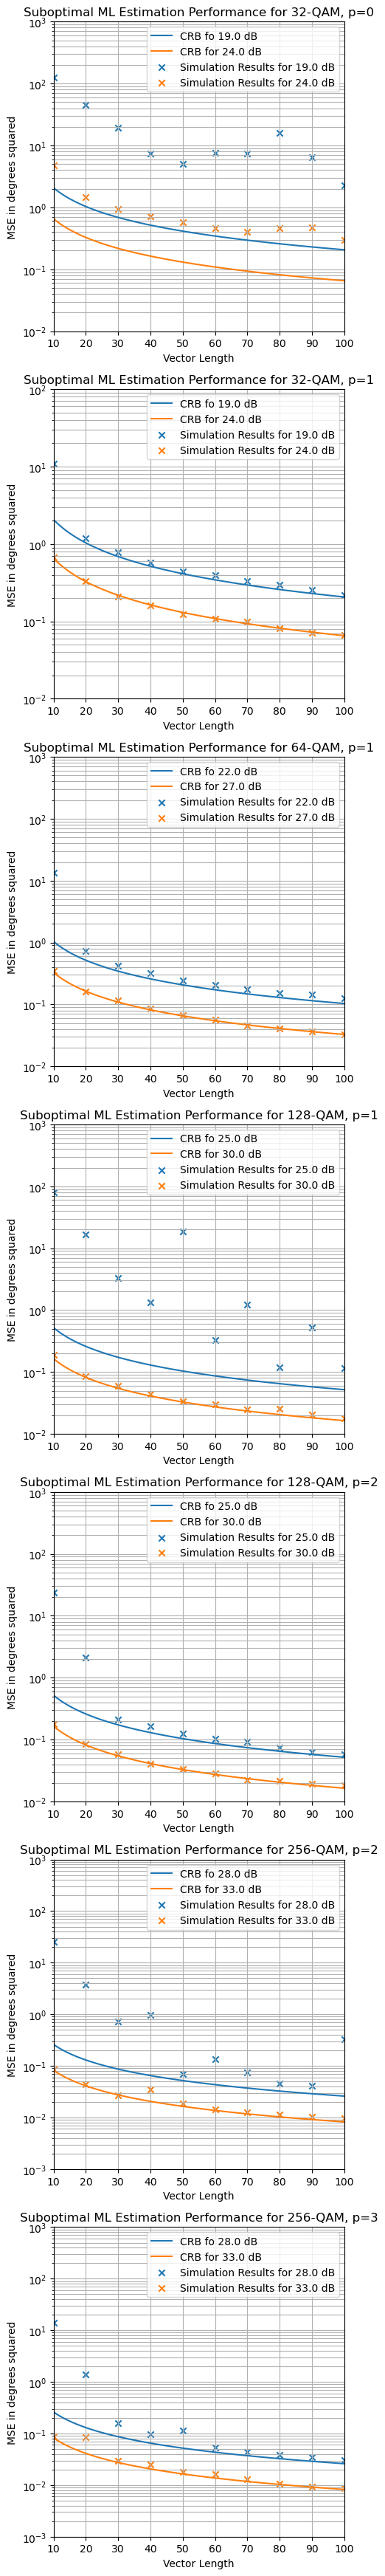

In [1]:
from thesisplots import graph_sml_results

graph_sml_results()

As you can see, if the value of p is too low, then the results are not accurate. Thus as the constellation size increases, p must also increase to include a larger number of symbols. The SML algorithm, at the cost of a small amount of accuracy, greatly improves on the speed of the ML algorithm for larger constellations. The SML algorithm performed about 4 times faster for the 256-QAM constellation. However, it is still much too slow to be practical for real world applications.

# CHAPTER III

**Power Law Phase Estimation**

The problem with both of the previous methods for estimating $\theta$ is their speed. Calculating the log likelihood for several different offsets takes too long. It would be ideal if instead of calculating the log-likelihood at several different points and finding the maximum from those calculated samples, we could simply calculate theta directly. The **Power Law (PL)** algorithm provides an avenue we can take to accomplish this. The main idea of the power law algorithm is to manipulate the received data to give us an indication of what the phase offset might be. The method of doing this is to raise each received signal to the power of 4. Because the constellations are indistinguishable from their unrotated counterparts when rotated by a factor of $\frac{\pi}{2}$ radians, we can safely raise all of the symbols to the power of 4. Below is a graph showing a 256-QAM constellation with each symbol raised to the power of 4 and multiplied by -1. This should help visualize why we are choosing to do this.

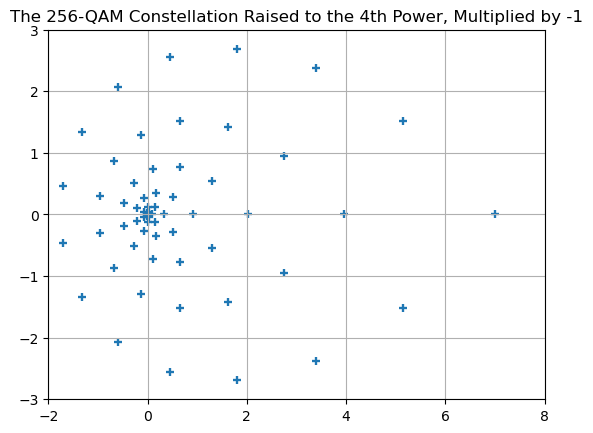

In [1]:
from thesisplots import plot_qam_4th_pow

plot_qam_4th_pow()

When raised to the 4th power, the constellation forms a tear-drop shape. By measuring which direction the points are skewed in after this operation, we can obtain a guess for the phase offset. To demonstrate this more explicitly, there is an interactive plot below. Move the slider to change the phase offset and observe what happens to the constellation after the operation is applied.

In [1]:
from ipywidgets import interact, fixed
from thesislib import *
from thesisplots import pl_offset_demonstration

qam = qam256_new()

interact(pl_offset_demonstration, qam=fixed(qam), phase_offset_deg=(0,90,3))

interactive(children=(IntSlider(value=45, description='phase_offset_deg', max=90, step=3), Output()), _dom_cla…

<function thesisplots.pl_offset_demonstration(qam, phase_offset_deg)>

The biggest takeaway from the example above is that the tear-drop shape is pointing in the direction given by 4 times the value of $\theta$. Thus, by summing all of the points in the set of received signals and finding the angle it makes with the positive real axis, we have an estimate for 4 times the phase offset. The formula for this is shown mathematically below.

<br>
<center>
    $\hat{\theta}_{PL} = \frac{1}{4} \arg \left( E[(\bar c_i)^4] \sum \limits _{k = 1}^{K} r(k)^4 \right)$
</center>

where $\bar c_i$ is the complex conjugate of a symbol in the constellation. Because all of our constellations are symmetrical over the real axis, this expected value is equivalent to $E[c_i^4]$, which is a real, negative constant for each constellation. It is worth pointing out that for the 32-QAM and 128-QAM constellations, results will be less accurate because they lack points in the corners, which give the strongest indication of the phase offset. These shapes have disproportionately more points located near the origin, which introduces more additive and self-noise. These effects can be quantified, and a table of the additive noise coefficients ($B_1$) and the self-noise coefficients ($B_2$) for each constellation size is shown below. Higher numbers indicate larger amounts of introduced noise.

| Constellation |  $B_1$  |  $B_2$ |
| -------------:| -------:| ------:|
|     32-QAM    | 52.6316 | 3.1413 |
|     64-QAM    |  5.8081 | 0.1674 |
|    128-QAM    | 62.0675 | 3.7929 |
|    256-QAM    |  6.2685 | 0.2019 |

If you would like to know more about how these values are calculated, I recommend looking at the paper cited as #9 in the thesis, which can be found here: https://ieeexplore.ieee.org/document/310611

Given in this paper is also a formula for the approximate MSE for the power law algorithm. This will be plotted along with the results of the PL algorithm. The formula for the approximate MSE is given as

<br>
<center>
    MSE $= \sigma_{\hat{\theta}_{PL}}^2 \approx \frac{B_1}{2 K \gamma} + \frac{B_2}{K}$
</center>

This algorithm performs significantly faster than both the ML and SML algorithms. Only one value needs to be calculated for the power law estimation, so the results can be easily calculated for a much broader range of values. These tests were run for 10,000 iterations, as specified in the thesis. See the results for the power law algorithm below.

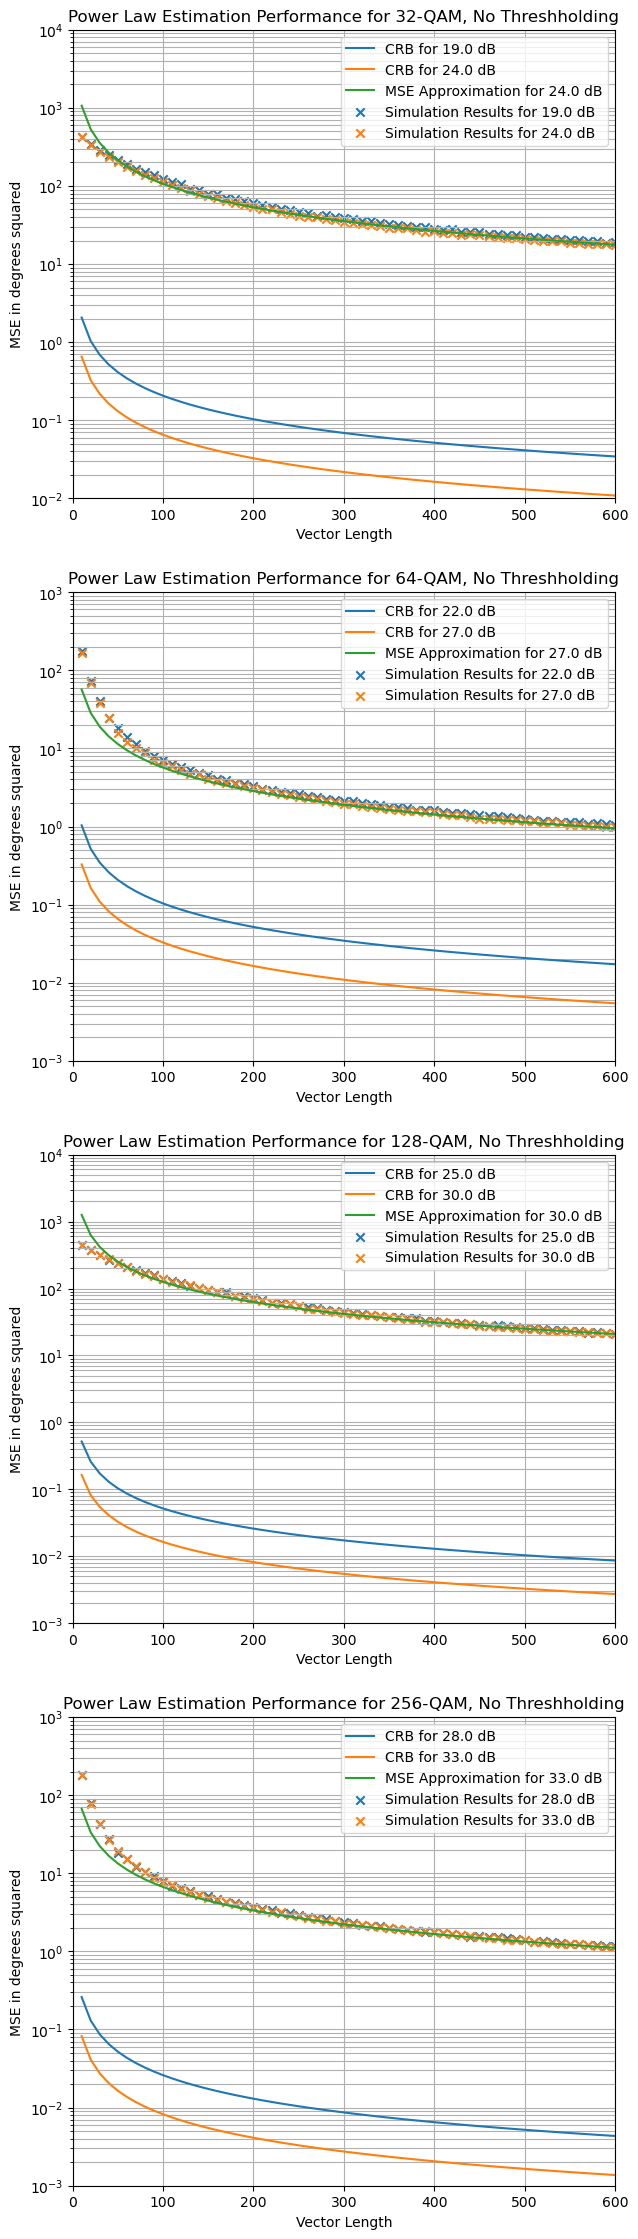

In [1]:
from thesisplots import graph_pl_results

graph_pl_results()

Clearly this algorithm performs much worse than the first two in terms of accuracy. The next algorithm seeks to improve the results of this one without sacrificing speed.

**The Power Law with Thresholding**

# TODO

- ~~Check if log-likelihood function is twice differentiable for Newton's Method, or if the current (computationally expensive) numerical method is fine~~

- ~~SML Algorithm implementation~~

- ~~Explain N0 value (power = 1 so snr = power/n0 yields n0 = 1/snr)~~

- ~~Implement Power Law Phase Estimation~~

- Implement PLT algorithm